* https://towardsdatascience.com/transformers-141e32e69591
* https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
* https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9#:~:text=LSTMs%20use%20a%20series%20of,each%20their%20own%20neural%20network.
* https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well
* https://www.youtube.com/watch?v=ROLugVqjf00
* https://lilianweng.github.io/posts/2019-03-14-overfit/    (very important)
* https://atcold.github.io/pytorch-Deep-Learning/en/week11/11-3/
* https://towardsdatascience.com/choosing-and-customizing-loss-functions-for-image-processing-a0e4bf665b0a
* https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4
* https://embracingtherandom.com/machine-learning/tensorflow/ranking/deep-learning/learning-to-rank-part-2/#where-do-probabilities-fit-into-listnet
* https://www.topbots.com/attention-for-time-series-forecasting-and-classification/

In [1]:
NR_OF_PIXELS=3
BACKWARD_WINDOW_LENGTH = 4
FORWARD_WINDOW_LENGTH = 1

# LIBRARIES

In [2]:
import MetaTrader5 as mt5

import pandas as pd

from datetime import datetime

import pytz

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import entropy
from scipy.stats import ks_2samp

import tensorflow as tf
import tensorflow_ranking as tfr

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import KBinsDiscretizer

import pyspark
from pyspark.sql import SparkSession

from IPython import display

import time

# CONFIG

In [3]:
pd.set_option('display.float_format', '{:.5f}'.format)

In [4]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2022, 8, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2022, 11, 1, tzinfo=gc_o_TIME_ZONE)

In [5]:
sCategory = 'Stocks\\Germany\\Banking & Investment Services\\Banks\\'

# SOURCE DATA

In [6]:
def dfFetchSampleDataFromMt(p_sSymbolName):
    aOhlSample = mt5.copy_rates_range(
        p_sSymbolName,
        mt5.TIMEFRAME_M1,
        gc_dt_FROM, 
        gc_dt_TO
    )

    dfToReturn = pd.DataFrame(aOhlSample)
    if 'time' in list(dfToReturn.columns):
        return dfToReturn
    else:
        return dfFetchSampleDataFromMt(p_sSymbolName)
    
    

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
tplSymbols = mt5.symbols_get()
dfSymbols = pd.DataFrame(tplSymbols, columns = tplSymbols[0]._asdict().keys())


def aGetUniqueCategories(tplSymbols):
    aCategories = []
    for i in range(0, len(tplSymbols)):
        sCategory = '\\'.join(tplSymbols[i]._asdict()['path'].split('\\')[:-1]) +'\\'
        if sCategory not in aCategories:
            aCategories.append(sCategory)
    return aCategories


aCategories = aGetUniqueCategories(tplSymbols)


dfFilteredSymbols = dfSymbols[dfSymbols['path'].str.contains(sCategory, regex=False) == True]

dfOhlc = pd.DataFrame()

for iIndex, srsRow in dfFilteredSymbols.iterrows():
    sSymbolName = dfFilteredSymbols.loc[iIndex, 'name']
    iDigit  = dfFilteredSymbols.loc[iIndex, 'digits']
    
    dfOhlcSample =  dfFetchSampleDataFromMt(sSymbolName)
    
    if len(dfOhlcSample) > 500:
        dfOhlcSample['EXCHANGE_RATE'] =  sSymbolName
        dfOhlcSample['DIGIT_SENSITIVITY'] =  iDigit
        dfOhlc = dfOhlc.append(dfOhlcSample)
        
dfOhlc.reset_index(drop = True, inplace = True)

In [7]:
dfOhlc['time'] = pd.to_datetime(dfOhlc['time'], unit = 's')

# PREPROCESS

In [8]:
dfPrep = dfOhlc.copy()

## Add Last Digits

In [9]:
# To-be-continued

## Add Candlestick Features

In [10]:
dfPrep['RETURN'] =  (dfPrep['close']-dfPrep['open'])/dfPrep['open']

dfPrep["UPPER_SHADOW"] =( dfPrep["high"] - dfPrep[['close', 'open']].max(axis=1))/ dfPrep[['close', 'open']].max(axis=1)
dfPrep["LOWER_SHADOW"] = (dfPrep[['close', 'open']].min(axis=1) - dfPrep["low"])/dfPrep["low"]

## Add Seasonal Features

In [11]:
dfPrep.loc[:, 'MINUTE'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.minute
dfPrep.loc[:, 'HOUR'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.hour
dfPrep.loc[:, 'DAY_OF_WEEK'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.day_of_week
dfPrep.loc[:, 'DAY_OF_MONTH'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.day

## Calculate Support and Resistence Levels

K-Means Algorithm used to identify the support and resistence levels.
* https://medium.com/@judopro/using-machine-learning-to-programmatically-determine-stock-support-and-resistance-levels-9bb70777cf8e

In [12]:
# def bIsSupport(df, l, n1, n2):
#     for i in range(l-n1+1, l+1):
#         if (df['low'].iloc[i] > df['low'].iloc[i-1]):
#             return 0
        
#     for i in range(l+1, l+n2+1):
#         if (df['low'].iloc[i] < df['low'].iloc[i-1] ):
#             return 0
        
#     return 1


# def bIsResistence(df, l, n1, n2):
#     for i in range(l-n1+1, l+1):
#         if (df['high'].iloc[i] > df['high'].iloc[i-1]):
#             return 0
        
#     for i in range(l+1, l+n2+1):
#         if (df['high'].iloc[i] < df['high'].iloc[i-1] ):
#             return 0
        
#     return 1



# n1 = 4
# n2 = 4
# for i in range(0, len(dfPrep)):
#     dfPrep.iloc[i].loc['IS_SUPPORT'] = bIsSupport(dfPrep, i, n1, n2)
#     dfPrep.iloc[i].loc['IS_RESISTENCE'] = bIsResistence(dfPrep, i, n1, n2)



# FEATURE ENGINEERING

In [13]:
def GET_DATASETS_2(dfPreprocessed, dfTimeStamps):
    #Create PySpark SparkSession
    oSparkSess = SparkSession.builder \
        .master("local[1]") \
        .appName("SparkByExamples.com") \
        .getOrCreate()

    oSparkSess.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

    def dfGetPixels(df, iFrom, iTo, dfTimeStamps):
        
        df['from_time'] = df['time'] + pd.DateOffset(hours=iFrom)
        df['to_time'] = df['time'] + pd.DateOffset(hours=iTo)

        df = df[['to_time', 'from_time', 'time','close', 'high']]
        
        
        
        sdf= oSparkSess.createDataFrame(df)
        sdf.createOrReplaceTempView("sdf")

        dfPriceAnalysis =  oSparkSess.sql("""
            SELECT 
                t.from_time, 
                t.to_time,
                t.time, 
                t.close, 
                t.HISTORICAL_HIGH, 
                count(*) AS NR_OF_MINS
            FROM
            (
                SELECT df1.*, df2.high as HISTORICAL_HIGH FROM sdf df1
                INNER JOIN sdf df2
                ON df2.time >= df1.from_time and df2.time < df1.to_time
            ) t
            GROUP BY t.from_time, t.to_time, t.time, t.close, t.HISTORICAL_HIGH
            ORDER BY t.from_time, t.to_time, t.time, t.close, t.HISTORICAL_HIGH
        """).toPandas()
        
                   
        
        dfToReturn = pd.DataFrame(
            data =  np.zeros((len(dfTimeStamps) , NR_OF_PIXELS)).astype(int), 
            columns = list(range(0,NR_OF_PIXELS)),
            index = dfTimeStamps['TIME_STAMP']
        )
        
        
        if len(dfPriceAnalysis)==0:
            return dfToReturn
        else:
            dfPriceAnalysis.sort_values(['time', 'HISTORICAL_HIGH'], inplace = True)
            dfPriceAnalysis.loc[:, 'DIFF'] =  (dfPriceAnalysis.loc[: , 'HISTORICAL_HIGH']-dfPriceAnalysis.loc[:, 'close'])/dfPriceAnalysis.loc[:, 'close']
            
            oDiscretizer = KBinsDiscretizer(n_bins=NR_OF_PIXELS, encode='ordinal', strategy='quantile')

            dfSample = pd.DataFrame(
                data = np.arange(-0.005, 0.005 , (0.010/NR_OF_PIXELS)),
                columns = ['DIFF']
            )
            oDiscretizer.fit(dfSample)

            dfPriceAnalysis.loc[:, 'DIFF_BIN'] =  oDiscretizer.transform(dfPriceAnalysis.loc[:, ['DIFF']]).astype(int)
            
            dfPixel = dfPriceAnalysis.pivot_table(index = 'time', columns = 'DIFF_BIN', values = 'NR_OF_MINS', aggfunc = 'sum', fill_value = 0)
            
            dfToReturn.loc[dfPixel.index, dfPixel.columns] = dfPixel.values

            return dfToReturn

    
    df = dfPreprocessed.copy()
   
    aExchangeRates = list(df['EXCHANGE_RATE'].unique())
    # build input dataset
    X = []
    Y = []
    
    for sExchangeRate in aExchangeRates:
        X_single_exc = []
        
        df_single_exc = df.query('EXCHANGE_RATE == @sExchangeRate')
        df_single_exc = df_single_exc[['time','close', 'high']].fillna(0)
        
        
        for i in range(-BACKWARD_WINDOW_LENGTH, 0):
            iFrom = i
            iTo = i +1

            print(iFrom)
            dfPixel = dfGetPixels(df_single_exc, iFrom, iTo, dfTimeStamps)
            dfPixel= dfPixel[BACKWARD_WINDOW_LENGTH * 60:]
            dfPixel= dfPixel[:-FORWARD_WINDOW_LENGTH * 60]
            

            if len(X_single_exc) == 0:
                X_single_exc = dfPixel.values
            else:
                X_single_exc = np.append(X_single_exc, dfPixel.values, axis = 1)
        
        # batch_size, time_steps, feature_size, channel_size
        X_single_exc = X_single_exc.reshape((-1, BACKWARD_WINDOW_LENGTH, dfPixel.shape[1], 1))
        
        if len(X) == 0:
            X = X_single_exc
        else:
            X = np.append(X, X_single_exc, axis = 3)
        


        # build output dataset
        Y_single_exc = []
        for i in range(0, FORWARD_WINDOW_LENGTH):
            iFrom = i
            iTo = i +1

            print(iFrom)
            dfPixel = dfGetPixels(df_single_exc, iFrom, iTo, dfTimeStamps)

            dfPixel= dfPixel[BACKWARD_WINDOW_LENGTH * 60:]
            dfPixel= dfPixel[:-FORWARD_WINDOW_LENGTH * 60]

            if len(Y_single_exc) == 0:
                Y_single_exc = dfPixel.values
            else:
                Y_single_exc = np.append(Y_single_exc, dfPixel.values, axis = 1)
        
        # batch_size, time_steps, feature_size, channel_size
        Y_single_exc = Y_single_exc.reshape((-1, FORWARD_WINDOW_LENGTH, dfPixel.shape[1], 1))
        
        if len(Y) == 0:
            Y = Y_single_exc
        else:
            Y = np.append(Y, Y_single_exc, axis = 3)
            
    # # divide all the minutes to 60 to normalize between 0-1 (1hr contains maximum 60 1m candlesticks)
    X = X/60
    Y = Y/60
    
    # identify samples where there is no available input and output and drop such samples from both X and Y datasets.
    ixToDrop = np.nonzero(np.sum(X, axis = (1,2,3))==0)[0]
    ixToDrop = np.union1d(ixToDrop, np.nonzero(np.sum(Y, axis = (1,2,3))==0)[0])

    X = np.delete(X, ixToDrop, axis = 0)
    Y = np.delete(Y, ixToDrop, axis = 0)

    return X, Y

# TIME2VEC

In [29]:
# to-be-developed... This is not a model... This is a layer...
# We will use weather to include this layer within our model or not... (maybe an involvement coefficient between 0 and 1)

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer


class Time2Vec(Layer):
    def __init__(self, kernel_size, periodic_activation='sin'):
        '''
        
        :param kernel_size:         The length of time vector representation.
        :param periodic_activation: The periodic activation, sine or cosine, or any future function.
        '''
        super(Time2Vec, self).__init__(
            trainable=True,
            name='Time2VecLayer_'+periodic_activation.upper()
        )
        
        self.k = kernel_size
        self.p_activation = periodic_activation
    
    def build(self, input_shape):
        # While i = 0
        self.wb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        self.bb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        # Else needs to pass the periodic activation
        self.wa = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )
        
        self.ba = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )
        
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        '''
        
        :param inputs: A Tensor with shape (batch_size, feature_size, 1)
        :param kwargs:
        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        bias = self.wb * inputs + self.bb
        if self.p_activation.startswith('sin') :
            wgts = K.sin(K.dot(inputs, self.wa) + self.ba)
        elif self.p_activation.startswith('cos') :
            wgts = K.cos(K.dot(inputs, self.wa) + self.ba)
        else:
            raise NotImplementedError('Neither sine or cosine periodic activation be selected.')
        return K.concatenate([bias, wgts], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.k + 1)

# BASELINE

In [15]:
# dfX, dfY = GET_DATASETS_1(dfPrep)

# # # independent component analysis
# # df = dfX.copy()
# # oIca = FastICA(n_components=7, random_state=0, whiten='unit-variance')

# # df = pd.DataFrame(
# #     data = oIca.fit_transform(df),
# #     index = df.index
# # )
# # df = df.add_prefix('ICA_')
# # dfX = df

# # # remove outliers from X
# # ixOutliers = dfX[(((dfX-dfX.mean())/dfX.std()).abs() > 3 ).any(axis = 1) == True].index
# # dfX.drop(ixOutliers, inplace = True)

# # # remove outliers from Y
# # ixOutliers = dfY[(((dfY-dfY.mean())/dfY.std()).abs() > 3 ).any(axis = 1) == True].index
# # dfY.drop(ixOutliers, inplace = True)



# # standarize input
# oScalerInput = StandardScaler()
# df =  dfX.copy()

# df = pd.DataFrame(
#     data = oScalerInput.fit_transform(df),
#     columns =  df.columns,
#     index = df.index
# )

# dfX = df.copy()


# # standardize output
# oScalerOutput = StandardScaler()
# df =  dfY.copy()

# df = pd.DataFrame(
#     data = oScalerOutput.fit_transform(df),
#     columns =  df.columns,
#     index = df.index
# )

# dfY = df.copy()


# # # PCA input
# # oPca = PCA(0.90)
# # df = dfX.copy()

# # df = pd.DataFrame(
# #     data = oPca.fit_transform(df),
# #     index = df.index
# # )
# # df = df.add_prefix('PCA_')
# # dfX = df.copy()


# # split data to train-validation-test

# c_fTrainingRatio = 0.70
# c_fValidationRatio = 0.28
# c_fTestRatio = 0.02

# ixTrain,ixTest = train_test_split(
#     dfX.index,
#     test_size=1-c_fTrainingRatio,
#     shuffle=False,
#     random_state = 1
# )

# ixValidation,ixTest= train_test_split(
#     ixTest,
#     test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
#     shuffle=False,
#     random_state = 1
# )


# dfX_train = dfX.loc[ixTrain]
# dfX_validation = dfX.loc[ixValidation]
# dfX_test = dfX.loc[ixTest]

# dfY_train = dfY.loc[ixTrain]
# dfY_validation = dfY.loc[ixValidation]
# dfY_test = dfY.loc[ixTest]


# # check identicality of distributions
# df = dfX.copy()
# dfDistAnalysis = pd.DataFrame(columns = ['FEATURE', 'TRAIN_VAL', 'TRAIN_TEST', 'VAL_TEST'])
# for sCol in df.columns:
#     # The null hypothesis is that the two distributions are identical
#     # If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.
#     fStatsTrainVal, fPValueTrainVal = ks_2samp(
#         df.loc[ixTrain, sCol],
#         df.loc[ixValidation, sCol]
#     )

#     fStatsTrainTest, fPValueTrainTest = ks_2samp(
#         df.loc[ixTrain, sCol],
#         df.loc[ixTest, sCol]
#     )

#     fStatsValTest, fPValueValTest = ks_2samp(
#         df.loc[ixValidation, sCol],
#         df.loc[ixTest, sCol]
#     )
    
#     dfDistAnalysis = pd.concat(
#          [dfDistAnalysis,
#          pd.DataFrame(data = [[sCol, fPValueTrainVal,  fPValueTrainTest, fPValueValTest]], columns = dfDistAnalysis.columns)
#          ],
#         ignore_index=False
#     )

# print('identicality of distributions: \n\n {}'.format(dfDistAnalysis))



# # model development
# X_train = dfX_train.values
# X_validation = dfX_validation.values
# X_test = dfX_test.values


# Y_train = dfY_train.values
# Y_validation = dfY_validation.values
# Y_test = dfY_test.values


# # compile model
# aInput = tf.keras.Input(
#     shape =  X_train.shape[1]
# )

# aHidden1 = tf.keras.layers.Dense(
#     units = 300, 
#     kernel_initializer='normal',
#     # activity_regularizer = tf.keras.regularizers.L2(0.1),
#     use_bias = False
# )(aInput)

# aHidden1 = tf.keras.layers.BatchNormalization()(aHidden1)
# aHidden1 = tf.keras.layers.ReLU()(aHidden1)
# # aHidden1 = tf.keras.layers.Dropout(0.5)(aHidden1)


# aHidden2 = aHidden1
# # aHidden2 = tf.keras.layers.Dense(
# #     units = 300, 
# #      kernel_initializer='normal',
# #     activity_regularizer = tf.keras.regularizers.L2(0.1),  
# #     use_bias = False
# # )(aHidden1)

# # aHidden2 = tf.keras.layers.BatchNormalization()(aHidden2)
# # aHidden2 = tf.keras.layers.ReLU()(aHidden2)
# # aHidden2 = tf.keras.layers.Dropout(0.5)(aHidden2)

# aOutput = tf.keras.layers.Dense(
#     units = Y_train.shape[1],
#     kernel_initializer='normal',
#     # activation = 'ReLU'
# )(aHidden2)

# oModel = tf.keras.Model(inputs=aInput, outputs=aOutput)

# oLearningRateSchedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = 1e-03 * 2,
#     decay_steps=100000,
#     decay_rate=1e-02,
#     staircase=True)


# oOptimizer = tf.keras.optimizers.Adam(learning_rate=oLearningRateSchedule)

# oModel.compile(optimizer=oOptimizer,loss= tf.keras.losses.MeanSquaredError())

# tf.keras.utils.plot_model(oModel, show_shapes=True)

# print(oModel.summary())


# # fit model
# oEarlyStop = tf.keras.callbacks.EarlyStopping(
#     monitor = 'val_loss', 
#     mode = 'min', 
#     verbose = 0 , 
#     patience = 50, 
#     restore_best_weights = True)

# oModel.fit(
#     X_train, 
#     Y_train, 
#     epochs= 1000, 
#     batch_size=2**5, 
#     verbose=0, 
#     validation_data= (X_validation, Y_validation),
#     # callbacks=[oEarlyStop]
# )


# # show epoch history
# dfHistory = pd.DataFrame(oModel.history.history)

# plt.figure(figsize = (20, 8))
# sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
# sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
# plt.show()


# # test model
# a_Y_datasets = [Y_train, Y_validation]
# a_X_datasets = [X_train, X_validation]
# a_labels = ['train', 'validation'] 

# plt.figure(figsize = (20,8 ))
# for X,Y, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
#     aActual = oScalerOutput.inverse_transform(Y)
#     aPred = oScalerOutput.inverse_transform(oModel.predict(X))

#     df = pd.DataFrame(data = np.column_stack((aActual,aPred)),
#                  columns = ['ACTUAL', 'PREDICTION']
#                 )
    
#     fR2Score = round(r2_score(aActual, aPred), 1)
#     sLabel = '{}   r2: {}'.format(sLabel,fR2Score)
#     sns.scatterplot(data = df, x = 'ACTUAL', y = 'PREDICTION', label = sLabel)
# plt.show()

# GENERATIVE ADVERSARIAL NETWORK

In [16]:
# # define the discriminator model
# def define_discriminator(image_shape = Y[0].shape):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # source image input
#     in_src_image = tf.keras.layers.Input(shape=image_shape)
#     # target image input
#     in_target_image = tf.keras.layers.Input(shape=image_shape)
    
    
#     # concatenate images channel-wise
#     merged = tf.keras.layers.Concatenate()([in_src_image, in_target_image])
#     # C64
#     d = tf.keras.layers.Conv1D(64, 1, strides=1, padding='same', kernel_initializer=init)(merged)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # C128
#     d = tf.keras.layers.Conv1D(128, 1, strides=1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # C256
#     d = tf.keras.layers.Conv1D(256, 1, strides=1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # C512
#     d = tf.keras.layers.Conv1D(512, 1, strides=1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # second last output layer
#     d = tf.keras.layers.Conv1D(512, 1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # patch output
#     d = tf.keras.layers.Conv1D(1, 1, padding='same', kernel_initializer=init)(d)
#     patch_out = tf.keras.layers.Activation('sigmoid')(d)
#     # define model
#     model = tf.keras.Model([in_src_image, in_target_image], patch_out, name = 'DISCRIMINATOR_MODEL')

#     return model


# def discriminator_loss(disc_real_output, disc_generated_output):
#     loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
#     real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#     generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#     total_disc_loss = real_loss + generated_loss

#     return total_disc_loss


# # define an encoder block
# def define_encoder_block(layer_in, n_filters, batchnorm=True):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # add downsampling layer
#     g = tf.keras.layers.Conv1D(n_filters, 1, strides=1, padding='same', kernel_initializer=init)(layer_in)
#     # conditionally add batch normalization
#     if batchnorm:
#         g = tf.keras.layers.BatchNormalization()(g, training=True)
#     # leaky relu activation
#     g = tf.keras.layers.LeakyReLU(alpha=0.2)(g)
#     return g

# # define a decoder block
# def decoder_block(layer_in, skip_in, n_filters, dropout=True):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # add upsampling layer
#     g = tf.keras.layers.Convolution1DTranspose(n_filters, 1, strides=1, padding='same', kernel_initializer=init)(layer_in)
#     # add batch normalization
#     g = tf.keras.layers.BatchNormalization()(g, training=True)
#     # conditionally add dropout
#     if dropout:
#         g = tf.keras.layers.Dropout(0.5)(g, training=True)
#     # merge with skip connection
#     g = tf.keras.layers.Concatenate()([g, skip_in])
#     # relu activation
#     g = tf.keras.layers.Activation('relu')(g)
#     return g


# # define the standalone generator model
# def define_generator(image_shape=X[0].shape):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # image input
#     in_image = tf.keras.layers.Input(shape=image_shape)
#     # encoder model
    
#     e1 = define_encoder_block(in_image, 64, batchnorm=False)
#     e2 = define_encoder_block(e1, 128)
#     e3 = define_encoder_block(e2, 256)
#     e4 = define_encoder_block(e3, 512)
#     e5 = define_encoder_block(e4, 512)
#     e6 = define_encoder_block(e5, 512)
#     e7 = define_encoder_block(e6, 512)

    
#     # bottleneck, no batch norm and relu
#     b = tf.keras.layers.Conv1D(512, 1, strides=1, padding='same', kernel_initializer=init)(e7)
#     b = tf.keras.layers.Activation('relu')(b)
    
#     # decoder model
#     d1 = decoder_block(b, e7, 512)
#     d2 = decoder_block(d1, e6, 512)
#     d3 = decoder_block(d2, e5, 512)
#     d4 = decoder_block(d3, e4, 512, dropout=False)
#     d5 = decoder_block(d4, e3, 256, dropout=False)
#     d6 = decoder_block(d5, e2, 128, dropout=False)
#     d7 = decoder_block(d6, e1, 64, dropout=False)
    
    
#     # output
#     g = tf.keras.layers.Conv1DTranspose(FORWARD_WINDOW_LENGTH, 1, strides=1, padding='same', kernel_initializer=init)(d7)
#     out_image = tf.keras.layers.Activation('tanh')(g)
#     # define model
#     model = tf.keras.Model(in_image, out_image, name = 'GENERATOR_MODEL')
#     return model


# def generator_loss(disc_generated_output, gen_output, target):
#     loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
#     gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

#     # Mean absolute error
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

#     total_gen_loss = gan_loss + (LAMBDA * l1_loss)

#     return total_gen_loss, gan_loss, l1_loss


# oDiscriminator = define_discriminator()

# oGenerator = define_generator()

# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
# @tf.function
# def train_step(input_image, target, step):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         gen_output = oGenerator(input_image, training=True)
        
#         # disc_real_output is not so much applicable for exchange rate prediction.
#         # because, in image recognition, templates of both input and target should match.
#         # in time series, template of backward and forward should be different.
#         # due to this reason, we should either generate different type of loss function.
#         # or we should use GAN for another purpose than pix2pix.
#         disc_real_output = oDiscriminator([input_image, target], training=True)
#         disc_generated_output = oDiscriminator([input_image, gen_output], training=True)

#         gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#         disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#         generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
#         discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

#         with summary_writer.as_default():
#             tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#             tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#             tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#             tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

            
# def generate_images(model, test_input, tar):
#     prediction = model(test_input, training=True)
    

#     display_list = [test_input[0], tar[0], prediction[0]]
#     title = ['Input Image', 'Ground Truth', 'Predicted Image']

#     for i in range(3):
#         plt.figure(figsize=(15, 15))
#         plt.subplot(1, 3, i+1)
#         plt.title(title[i])
#         # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')
#         plt.show()

            
            
# X, Y = GET_DATASETS_2(dfPrep)
# # split data to train-validation-test
# c_fTrainingRatio = 0.70
# c_fValidationRatio = 0.28
# c_fTestRatio = 0.02

# X_train,X_test, Y_train, Y_test = train_test_split(
#     X,Y,
#     test_size=1-c_fTrainingRatio,
#     shuffle=False,
#     random_state = 1
# )

# X_validation, X_test,Y_validation, Y_test= train_test_split(
#     X_test,Y_test,
#     test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
#     shuffle=False,
#     random_state = 1
# )



# BATCH_SIZE = 50

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# validation_ds = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))

# example_input, example_target = next(iter(validation_ds.take(1)))
# example_input = tf.expand_dims(example_input, axis = 0)            
# example_target = tf.expand_dims(example_target, axis = 0)   


# start = time.time()

# i = 0
# for (input_image, target) in train_ds.batch(BATCH_SIZE):

#     if (i) % 1000 == 0:
#         display.clear_output(wait=True)

#         if i != 0:
#             print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#         start = time.time()
        
#         generate_images(oGenerator, example_input, example_target)
#         print(f"Step: {i//1000}k")

#     # input_image = tf.expand_dims(input_image, axis = 0)            
#     # target = tf.expand_dims(target, axis = 0)           
    
#     train_step(input_image, target, i)

#     # Training step
#     if (i+1) % 10 == 0:
#         print('.', end='', flush=True)
    
#     i = i +1



# LUONG'S ATTENTION

In [17]:
# df = dfPrep.query('EXCHANGE_RATE == "DBKGn.DE"')
# df.query('time >= "2022-10-15"', inplace = True)

# X, Y, df = GET_DATASETS_2(df)

# # split data to train-validation-test
# c_fTrainingRatio = 0.70
# c_fValidationRatio = 0.28
# c_fTestRatio = 0.02

# X_train,X_test, Y_train, Y_test = train_test_split(
#     X,Y,
#     test_size=1-c_fTrainingRatio,
#     shuffle=False,
#     random_state = 1
# )

# X_validation, X_test,Y_validation, Y_test= train_test_split(
#     X_test,Y_test,
#     test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
#     shuffle=False,
#     random_state = 1
# )



# ModelInput = tf.keras.Input(
#     shape=(NR_OF_PIXELS, BACKWARD_WINDOW_LENGTH))

# aEncoderInputs = tf.keras.layers.Permute((2,1))(ModelInput)

# aEncoderHiddens, aFinalH, aFinalC = tf.keras.layers.LSTM(300,
#                                                          return_state = True, 
#                                                          return_sequences = True,
#                                                          name = 'Lstm_Encoder'
#                                                         )(aEncoderInputs)
# aFinalH = tf.keras.layers.BatchNormalization(name = 'Encoder_Final_Hidden_State_Batch_Norm')(aFinalH)
# aFinalC = tf.keras.layers.BatchNormalization(name = 'Encoder_Final_Carry_State_Batch_Norm')(aFinalC)

# aDecoderInputs = tf.keras.layers.RepeatVector(FORWARD_WINDOW_LENGTH)(aFinalH)

# aDecoderHiddens = tf.keras.layers.LSTM(300, 
#                        return_state = False, 
#                        return_sequences = True
#                       )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

# aAttentions = tf.keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
# aAttentions = tf.keras.layers.Softmax()(aAttentions)

# aContextVector = tf.keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
# aContextVector = tf.keras.layers.BatchNormalization()(aContextVector)
# aContextVector = tf.keras.layers.concatenate([aContextVector, aDecoderHiddens])

# aDecoderOutputs = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Dense(150)
# )(aContextVector)

# aDecoderOutputs = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Dense(150)
# )(aDecoderOutputs)

# aDecoderOutputs = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Dense(NR_OF_PIXELS)
# )(aDecoderOutputs)

# aModelOutput = tf.keras.layers.Permute((2,1))(aDecoderOutputs)

# aModelOutput = tf.keras.layers.Softmax(axis = 1)(aModelOutput)

# oModel = tf.keras.Model(
#     inputs=ModelInput,
#     outputs=aModelOutput,
#     name = 'LUONG_ATTENTION_MODEL'
# )



# oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-04)
# oModel.compile(
#     loss = tf.keras.losses.CategoricalCrossentropy(), 
#     optimizer=oOptimizer
# )


# print(oModel.summary())


# # fit model
# oEarlyStop = tf.keras.callbacks.EarlyStopping(
#     monitor = 'val_loss', 
#     mode = 'min', 
#     verbose = 0 , 
#     patience = 20, 
#     restore_best_weights = True)

# oModel.fit(
#     X_train, 
#     Y_train, 
#     epochs= 1000, 
#     batch_size=2**8, 
#     verbose=1, 
#     validation_data= (X_validation, Y_validation),
#     callbacks=[oEarlyStop]
# )

# # show epoch history
# dfHistory = pd.DataFrame(oModel.history.history)

# plt.figure(figsize = (20, 8))
# sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
# sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
# plt.show()


# # test model
# a_Y_datasets = [Y_train, Y_validation]
# a_X_datasets = [X_train, X_validation]
# a_labels = ['train', 'validation'] 


# for X_to_visualzie,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
#     pred = oModel.predict(X_to_visualzie)
#     ground_true = Y_to_visualize 
#     for i in np.random.randint(low = 0,high = len(X_to_visualzie), size = 10):        
#         fig, axs = plt.subplots(1,2)
#         fig.suptitle('{}--{}'.format(sLabel, i))

#         axs[0].imshow(ground_true[i], cmap='gray')
#         axs[0].set_title( 'GROUND TRUE')

#         axs[1].imshow(pred[i], cmap='gray')
#         axs[1].set_title( 'PREDICTION')

#         plt.show()

# # this model should be enough capable to identify the times when the market is closed.
# # maybe we can add seasonal features in additon.
# # also, it doesn't predict well.
# # maybe a learn-to-rank model could be helpful.
# # also implement the R2s for each time_step-pixel_bin pairs.

        
# #     aActual = oScalerOutput.inverse_transform(Y)
# #     aPred = oScalerOutput.inverse_transform(oModel.predict(X))

# #     df = pd.DataFrame(data = np.column_stack((aActual,aPred)),
# #                  columns = ['ACTUAL', 'PREDICTION']
# #                 )
    
# #     fR2Score = round(r2_score(aActual, aPred), 1)
# #     sLabel = '{}   r2: {}'.format(sLabel,fR2Score)
# #     sns.scatterplot(data = df, x = 'ACTUAL', y = 'PREDICTION', label = sLabel)
# # plt.show()


# # tf.keras.utils.plot_model(oModel,  show_shapes=True)

# BAHDENAU'S ATTENTION

In [18]:
# to-be-developed

# VASWANI'S ATTENTION

In [19]:
dfTimeStamps = pd.DataFrame(
    data = pd.date_range(
        start='2022-08-01 00:00', 
        end='2022-11-01 00:00', freq = 'min'
    ),
    columns  = ['TIME_STAMP']
)

dfTimeStamps.query('TIME_STAMP.dt.day_of_week not in (6,7)', inplace = True)
dfTimeStamps.query(' 10 <= TIME_STAMP.dt.hour <= 18', inplace = True)
dfTimeStamps.drop(dfTimeStamps.query(' TIME_STAMP.dt.hour == 18 and TIME_STAMP.dt.minute >= 30 ', inplace = False).index, inplace = True)
dfTimeStamps.reset_index(drop = True, inplace = True)

df = dfPrep.copy()
df.query('time >= "2022-08-01" and EXCHANGE_RATE in ("CBKG.DE")', inplace = True)

iNrOfExchangeRates = len(df['EXCHANGE_RATE'].unique())
X, Y = GET_DATASETS_2(df, dfTimeStamps)

-4
-3
-2
-1
0


Epoch 1/1000
23/23 [==============================] - 9s 191ms/step - loss: 0.5209 - val_loss: 0.5151
Epoch 2/1000
23/23 [==============================] - 3s 131ms/step - loss: 0.4799 - val_loss: 0.4549
Epoch 3/1000
23/23 [==============================] - 3s 141ms/step - loss: 0.4214 - val_loss: 0.3784
Epoch 4/1000
23/23 [==============================] - 3s 117ms/step - loss: 0.3745 - val_loss: 0.3456
Epoch 5/1000
23/23 [==============================] - 2s 107ms/step - loss: 0.3603 - val_loss: 0.3469
Epoch 6/1000
23/23 [==============================] - 2s 101ms/step - loss: 0.3553 - val_loss: 0.3475
Epoch 7/1000
23/23 [==============================] - 2s 105ms/step - loss: 0.3535 - val_loss: 0.3458
Epoch 8/1000
23/23 [==============================] - 3s 120ms/step - loss: 0.3508 - val_loss: 0.3449
Epoch 9/1000
23/23 [==============================] - 3s 117ms/step - loss: 0.3485 - val_loss: 0.3439
Epoch 10/1000
23/23 [==============================] - 3s 115ms/step - loss: 0.348

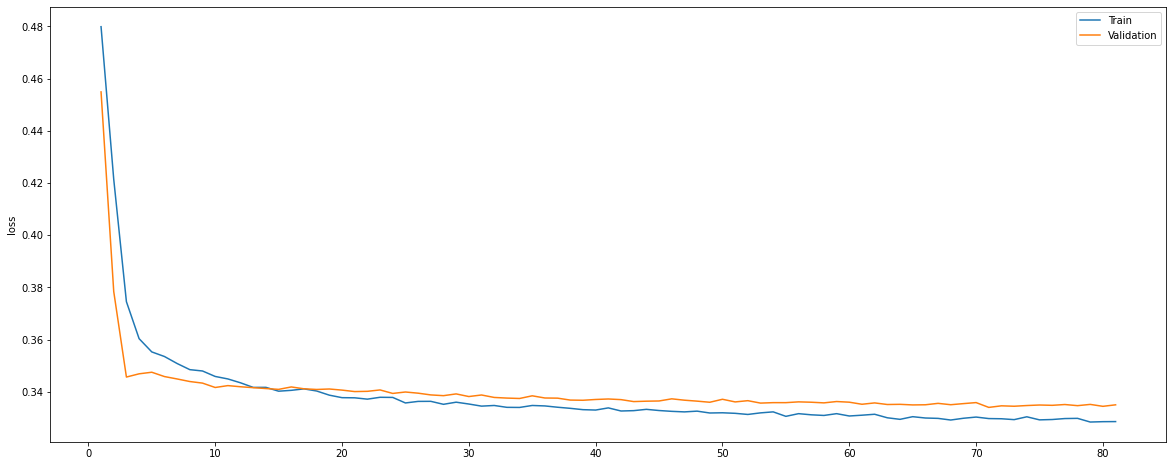

In [25]:
# split data to train-validation-test
c_fTrainingRatio = 0.70
c_fValidationRatio = 0.28
c_fTestRatio = 0.02

X_train,X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=1-c_fTrainingRatio,
    shuffle=False,
    random_state = 1
)

X_validation, X_test,Y_validation, Y_test= train_test_split(
    X_test,Y_test,
    test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
    shuffle=False,
    random_state = 1
)

X_train = X_train[:,:,:,0]
X_validation = X_validation[:,:,:,0]
X_test = X_test[:,:,:,0]

Y_train = Y_train[:,:,:,0]
Y_validation = Y_validation[:,:,:,0]
Y_test = Y_test[:,:,:,0]


# compile model
def transformer_encoder(inputs):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=128, num_heads=4, dropout=0.1)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)

    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return res


ModelInput = tf.keras.Input(
    shape=(BACKWARD_WINDOW_LENGTH, NR_OF_PIXELS))

W = ModelInput
for _ in range(1):
    W = transformer_encoder(W)
    
W = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(W)
for _ in range(2):
    W = tf.keras.layers.Dense(128)(W)
    W = tf.keras.layers.ReLU()(W)
    W = tf.keras.layers.Dropout(0.5)(W)

W = tf.keras.layers.Flatten()(W)
W = tf.keras.layers.Dense(FORWARD_WINDOW_LENGTH* NR_OF_PIXELS)(W)
W = tf.keras.layers.Reshape((FORWARD_WINDOW_LENGTH, NR_OF_PIXELS))(W)
W = tf.keras.layers.Softmax(axis = 2)(W)

ModelOutput = W
oModel = tf.keras.Model(ModelInput, ModelOutput, name = 'TRANSFORMER_MODEL')

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-04)
oModel.compile(
    loss = tf.keras.losses.KLDivergence(), 
    optimizer=oOptimizer
)

# # print(oModel.summary())

tf.keras.utils.plot_model(oModel, show_shapes=True)


# fit model
oEarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 10, 
    restore_best_weights = True)

oModel.fit(
    X_train, 
    Y_train, 
    epochs= 1000, 
    batch_size=2**10, 
    verbose=1, 
    validation_data= (X_validation, Y_validation),
    callbacks=[oEarlyStop]
)

# show epoch history
dfHistory = pd.DataFrame(oModel.history.history)

plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
plt.show()

725/725 [==============================] - 3s 4ms/step


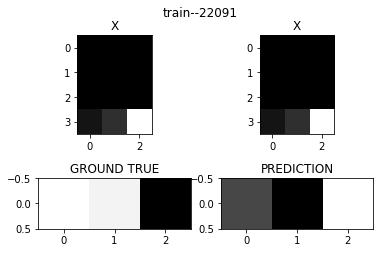

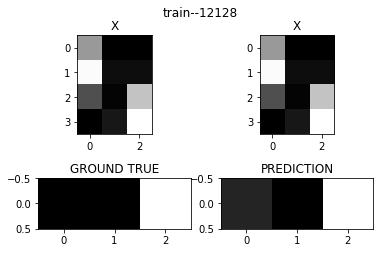

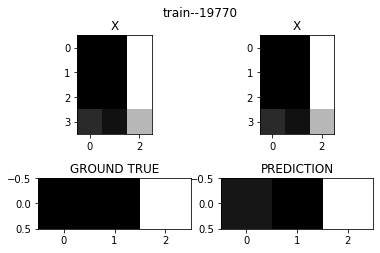

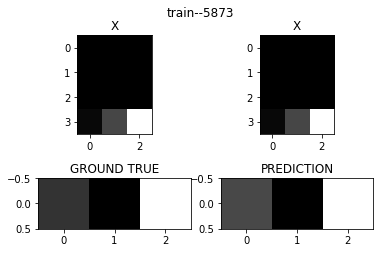

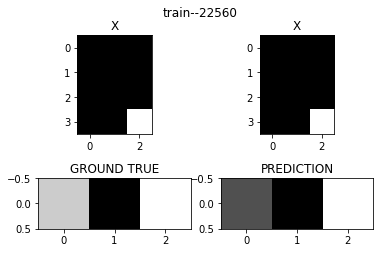

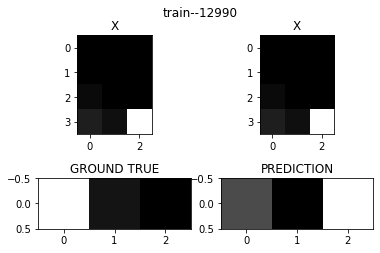

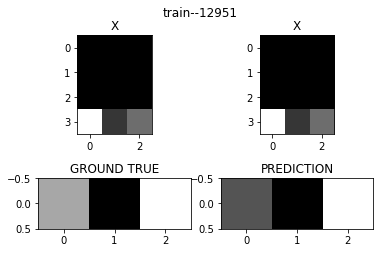

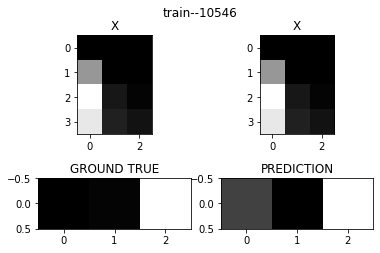

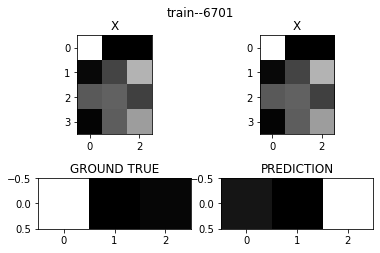

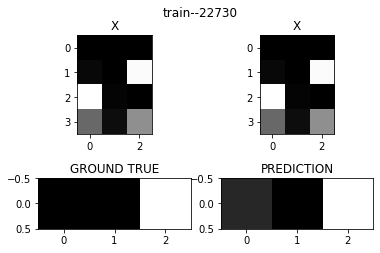

290/290 [==============================] - 1s 4ms/step


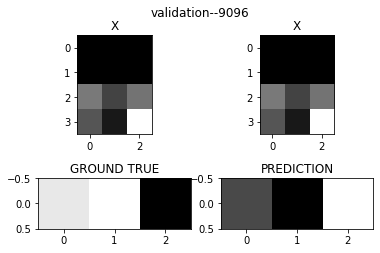

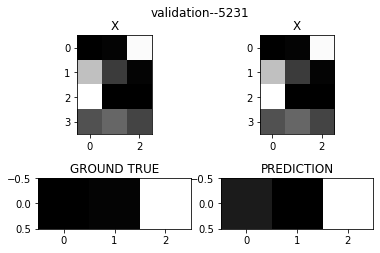

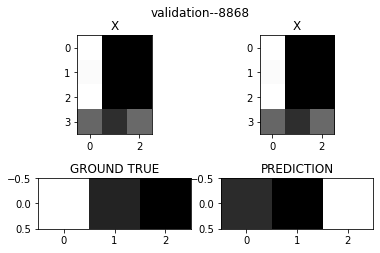

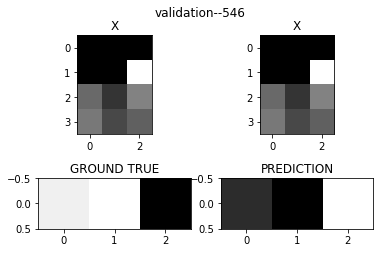

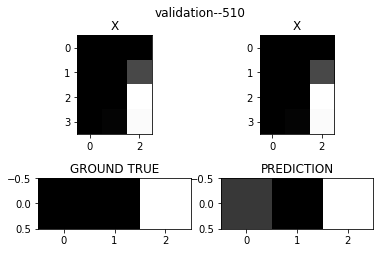

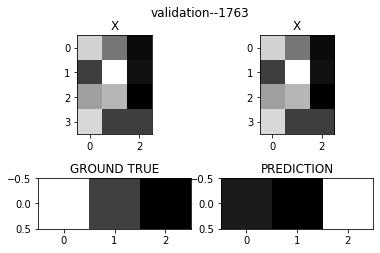

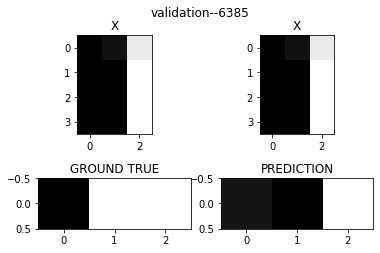

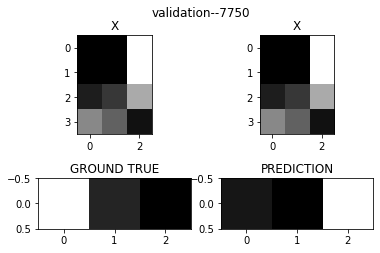

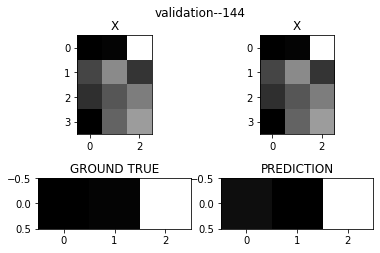

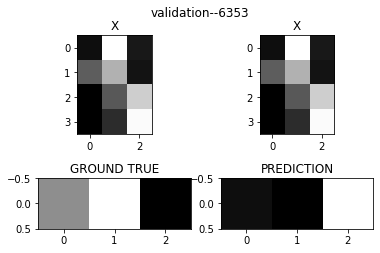

In [ ]:
# test model
a_Y_datasets = [Y_train, Y_validation]
a_X_datasets = [X_train, X_validation]
a_labels = ['train', 'validation'] 
for X_to_visualzie,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualzie)
    ground_true = Y_to_visualize
    for i in np.random.randint(low = 0,high = len(X_to_visualzie), size = 10):        
        fig, axs = plt.subplots(2,2)
        fig.suptitle('{}--{}'.format(sLabel, i))
        
        axs[0, 0].imshow(X_to_visualzie[i], cmap='gray')
        axs[0, 0].set_title( 'X')

        axs[0, 1].imshow(X_to_visualzie[i], cmap='gray')
        axs[0, 1].set_title( 'X')

    
        axs[1, 0].imshow(ground_true[i], cmap='gray')
        axs[1, 0].set_title( 'GROUND TRUE')

        axs[1, 1].imshow(pred[i], cmap='gray')
        axs[1, 1].set_title( 'PREDICTION')

        plt.show()

# # this model should be enough capable to identify the times when the market is closed.
# # maybe we can add seasonal features in additon.
# # also, it doesn't predict well.
# # maybe a learn-to-rank model could be helpful.
# # also implement the R2s for each time_step-pixel_bin pairs.

# #     aActual = oScalerOutput.inverse_transform(Y)
# #     aPred = oScalerOutput.inverse_transform(oModel.predict(X))

# #     df = pd.DataFrame(data = np.column_stack((aActual,aPred)),
# #                  columns = ['ACTUAL', 'PREDICTION']
# #                 )
    
# #     fR2Score = round(r2_score(aActual, aPred), 1)
# #     sLabel = '{}   r2: {}'.format(sLabel,fR2Score)
# #     sns.scatterplot(data = df, x = 'ACTUAL', y = 'PREDICTION', label = sLabel)
# # plt.show()


# # # tf.keras.utils.plot_model(oModel,  show_shapes=True)